In [7]:
%matplotlib inline
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from scipy import stats, integrate
import seaborn as sns

sns.set(color_codes=True)
plt.rcParams['figure.figsize'] = [15, 10]


In [8]:
analysis_id = '66fb9766-26e7-4bed-bdf9-0fbfbc8d6c7e'
data_file = 'output/%s/simulation_results.csv' % analysis_id
if not os.path.exists(data_file):
    raise Exception("path does not exist")

print("Loaded data file: %s" % data_file)

 # data_file_to_csv()
dataset = pd.read_csv(data_file)
# this column is a redundant column
dataset = dataset.drop('DistrictCoolingOutletTemperature', 1)
# update some of the column names so they make sense to this model
dataset = dataset.rename(columns={
    'DistrictHeatingOutletTemperature': 'ETSInletTemperature',
    'DistrictHeatingInletTemperature': 'ETSHeatingOutletTemperature',
    'DistrictCoolingInletTemperature': 'ETSCoolingOutletTemperature',
})
dataset['DateTime'] = pd.to_datetime(dataset['DateTime'])

Loaded data file: output/66fb9766-26e7-4bed-bdf9-0fbfbc8d6c7e/simulation_results.csv


In [13]:
dataset.columns.values

array(['DateTime', 'Month', 'Day', 'DayofWeek', 'Hour', 'Minute',
       'SiteOutdoorAirDrybulbTemperature',
       'SiteOutdoorAirRelativeHumidity', 'HeatingElectricity',
       'CoolingElectricity', 'ETSHeatingOutletTemperature',
       'ETSCoolingOutletTemperature', 'ETSInletTemperature',
       'DistrictHeatingMassFlowRate', 'DistrictCoolingMassFlowRate',
       'DistrictHeatingHotWaterEnergy',
       'DistrictCoolingChilledWaterEnergy', '_id',
       'ambient_loop_temperature_setpoint.design_delta',
       'ambient_loop_temperature_setpoint.setpoint_temperature',
       'openstudio_results.annual_peak_electric_demand',
       'openstudio_results.district_cooling_ip',
       'openstudio_results.district_heating_ip',
       'openstudio_results.electricity_ip', 'openstudio_results.eui',
       'openstudio_results.total_site_eui',
       'openstudio_results.unmet_hours_during_occupied_cooling',
       'openstudio_results.unmet_hours_during_occupied_heating'],
      dtype=object)

In [14]:
dataset._id.describe()

count                                   262800
unique                                      30
top       606171e5-3517-4ab1-85fe-276c34014eae
freq                                      8760
Name: _id, dtype: object

In [15]:
temperature_vars = [
       'ETSInletTemperature',
       'SiteOutdoorAirDrybulbTemperature',
       'ETSHeatingOutletTemperature',
#        'ETSCoolingOutletTemperature',
#        'ETSInletTemperature',
       'ambient_loop_temperature_setpoint.setpoint_temperature'
     ]
temperature_series = dataset[temperature_vars]
temperature_series.describe()



,ETSInletTemperature,SiteOutdoorAirDrybulbTemperature,ETSHeatingOutletTemperature,ambient_loop_temperature_setpoint.setpoint_temperature
count,262800.000000,262800.000000,262800.000000,262800.000000
mean,22.103454,11.196929,21.749915,19.983271
std,4.526443,10.005738,4.804681,2.863695
min,11.469700,-16.100000,11.469500,15.186900
25%,18.895300,3.300000,18.476800,17.564989
50%,22.189200,10.600000,21.500700,19.897556
75%,25.754200,17.800000,25.754200,22.387736
max,31.717500,38.300000,31.717500,24.721784


Text(0,0.5,u'Temperature (deg C)')

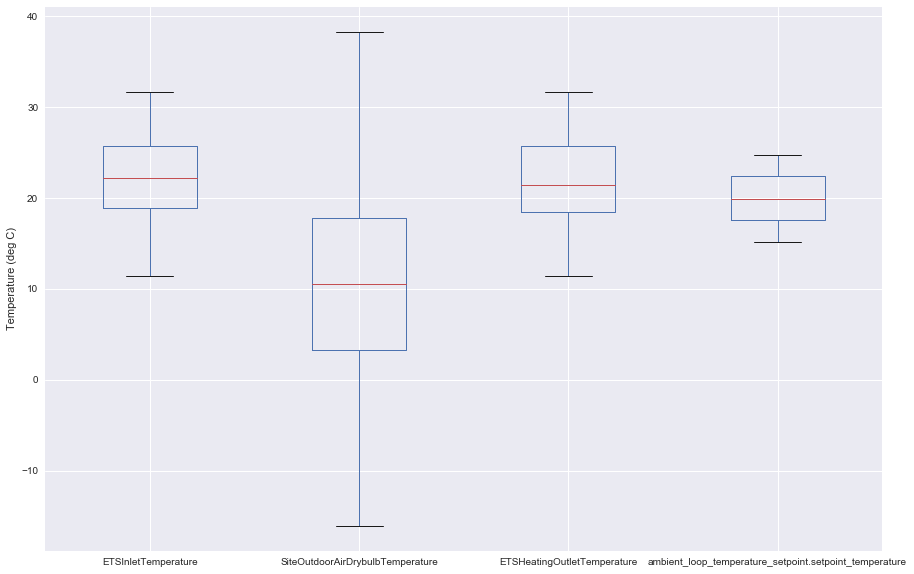

In [21]:
temperature_series.plot.box()
plt.ylabel("Temperature (deg C)")

In [22]:
mass_flow_series = dataset[[
  'DistrictCoolingMassFlowRate',  
  'DistrictHeatingMassFlowRate',
]]
mass_flow_series[mass_flow_series.DistrictCoolingMassFlowRate > 0].describe()
#mass_flow_series[mass_flow_series.DistrictCoolingMassFlowRate > 0].plot.box()
#mass_flow_series.plot.box()



,DistrictCoolingMassFlowRate,DistrictHeatingMassFlowRate
count,52637.000000,52637.000000
mean,0.721729,0.000662
std,0.910419,0.007987
min,0.000114,0.000000
25%,0.163268,0.000000
50%,0.457321,0.000000
75%,0.858956,0.000000
max,7.514100,0.541783


In [23]:
# get the time series data for 3/15
dataset.set_index('DateTime')
dataset.DateTime.describe()
# dataset.DateTime[15]

count                  262800
unique                   8760
top       2009-10-18 13:00:00
freq                       30
first     2009-01-01 01:00:00
last      2010-01-01 00:00:00
Name: DateTime, dtype: object

In [24]:

date_set = dataset[dataset["DateTime"].between("2009-03-01 01:00", "2009-03-10 00:00")]
date_set

,DateTime,Month,Day,DayofWeek,Hour,Minute,SiteOutdoorAirDrybulbTemperature,SiteOutdoorAirRelativeHumidity,HeatingElectricity,CoolingElectricity,...,ambient_loop_temperature_setpoint.design_delta,ambient_loop_temperature_setpoint.setpoint_temperature,openstudio_results.annual_peak_electric_demand,openstudio_results.district_cooling_ip,openstudio_results.district_heating_ip,openstudio_results.electricity_ip,openstudio_results.eui,openstudio_results.total_site_eui,openstudio_results.unmet_hours_during_occupied_cooling,openstudio_results.unmet_hours_during_occupied_heating
1416,2009-03-01 01:00:00,3,1,0,1,0,7.8,73,0.0,0.0,...,4.928615,19.155343,13.59835,52.075691,8.348816,45076.582774,38.937109,38.937109,1.0,4.0
1417,2009-03-01 02:00:00,3,1,0,2,0,7.8,82,0.0,0.0,...,4.928615,19.155343,13.59835,52.075691,8.348816,45076.582774,38.937109,38.937109,1.0,4.0
1418,2009-03-01 03:00:00,3,1,0,3,0,7.8,80,0.0,0.0,...,4.928615,19.155343,13.59835,52.075691,8.348816,45076.582774,38.937109,38.937109,1.0,4.0
1419,2009-03-01 04:00:00,3,1,0,4,0,7.8,76,0.0,0.0,...,4.928615,19.155343,13.59835,52.075691,8.348816,45076.582774,38.937109,38.937109,1.0,4.0
1420,2009-03-01 05:00:00,3,1,0,5,0,7.8,73,0.0,0.0,...,4.928615,19.155343,13.59835,52.075691,8.348816,45076.582774,38.937109,38.937109,1.0,4.0
1421,2009-03-01 06:00:00,3,1,0,6,0,7.8,73,0.0,0.0,...,4.928615,19.155343,13.59835,52.075691,8.348816,45076.582774,38.937109,38.937109,1.0,4.0
1422,2009-03-01 07:00:00,3,1,0,7,0,8.3,68,4638080.0,0.0,...,4.928615,19.155343,13.59835,52.075691,8.348816,45076.582774,38.937109,38.937109,1.0,4.0
1423,2009-03-01 08:00:00,3,1,0,8,0,8.3,68,4058460.0,0.0,...,4.928615,19.155343,13.59835,52.075691,8.348816,45076.582774,38.937109,38.937109,1.0,4.0
1424,2009-03-01 09:00:00,3,1,0,9,0,8.3,74,1676080.0,0.0,...,4.928615,19.155343,13.59835,52.075691,8.348816,45076.582774,38.937109,38.937109,1.0,4.0
1425,2009-03-01 10:00:00,3,1,0,10,0,7.8,82,945916.0,0.0,...,4.928615,19.155343,13.59835,52.075691,8.348816,45076.582774,38.937109,38.937109,1.0,4.0


In [25]:
# constrain to a specific building
date_set_single_building = date_set[date_set._id == '606171e5-3517-4ab1-85fe-276c34014eae']
date_set_single_building.describe()

,Month,Day,DayofWeek,Hour,Minute,SiteOutdoorAirDrybulbTemperature,SiteOutdoorAirRelativeHumidity,HeatingElectricity,CoolingElectricity,ETSHeatingOutletTemperature,...,ambient_loop_temperature_setpoint.design_delta,ambient_loop_temperature_setpoint.setpoint_temperature,openstudio_results.annual_peak_electric_demand,openstudio_results.district_cooling_ip,openstudio_results.district_heating_ip,openstudio_results.electricity_ip,openstudio_results.eui,openstudio_results.total_site_eui,openstudio_results.unmet_hours_during_occupied_cooling,openstudio_results.unmet_hours_during_occupied_heating
count,216.0,216.000000,216.000000,216.000000,216.0,216.000000,216.000000,2.160000e+02,216.000000,216.000000,...,216.000000,216.000000,2.160000e+02,2.160000e+02,216.00000,216.000000,2.160000e+02,2.160000e+02,216.0,216.0
mean,3.0,5.041667,2.453704,11.500000,0.0,6.334722,59.324074,5.346089e+05,2914.122685,16.322395,...,3.086545,17.564989,1.349573e+01,5.184506e+01,8.21412,45037.052681,3.884581e+01,3.884581e+01,1.0,4.0
std,0.0,2.595725,2.059055,6.938266,0.0,4.890774,19.697871,1.519233e+06,23624.983206,1.214378,...,0.000000,0.000000,3.560966e-15,1.424386e-14,0.00000,0.000000,7.121932e-15,7.121932e-15,0.0,0.0
min,3.0,1.000000,0.000000,0.000000,0.0,-3.900000,19.000000,0.000000e+00,0.000000,15.403900,...,3.086545,17.564989,1.349573e+01,5.184506e+01,8.21412,45037.052681,3.884581e+01,3.884581e+01,1.0,4.0
25%,3.0,3.000000,1.000000,5.750000,0.0,2.800000,44.000000,0.000000e+00,0.000000,15.435200,...,3.086545,17.564989,1.349573e+01,5.184506e+01,8.21412,45037.052681,3.884581e+01,3.884581e+01,1.0,4.0
50%,3.0,5.000000,2.000000,11.500000,0.0,7.200000,58.000000,0.000000e+00,0.000000,15.435800,...,3.086545,17.564989,1.349573e+01,5.184506e+01,8.21412,45037.052681,3.884581e+01,3.884581e+01,1.0,4.0
75%,3.0,7.000000,4.000000,17.250000,0.0,10.000000,76.000000,0.000000e+00,0.000000,18.090200,...,3.086545,17.564989,1.349573e+01,5.184506e+01,8.21412,45037.052681,3.884581e+01,3.884581e+01,1.0,4.0
max,3.0,10.000000,6.000000,23.000000,0.0,17.800000,100.000000,1.031430e+07,255227.000000,18.533400,...,3.086545,17.564989,1.349573e+01,5.184506e+01,8.21412,45037.052681,3.884581e+01,3.884581e+01,1.0,4.0


In [26]:
date_set_single_building

,DateTime,Month,Day,DayofWeek,Hour,Minute,SiteOutdoorAirDrybulbTemperature,SiteOutdoorAirRelativeHumidity,HeatingElectricity,CoolingElectricity,...,ambient_loop_temperature_setpoint.design_delta,ambient_loop_temperature_setpoint.setpoint_temperature,openstudio_results.annual_peak_electric_demand,openstudio_results.district_cooling_ip,openstudio_results.district_heating_ip,openstudio_results.electricity_ip,openstudio_results.eui,openstudio_results.total_site_eui,openstudio_results.unmet_hours_during_occupied_cooling,openstudio_results.unmet_hours_during_occupied_heating
97776,2009-03-01 01:00:00,3,1,0,1,0,7.8,73,0.0,0.0,...,3.086545,17.564989,13.49573,51.845061,8.21412,45037.052681,38.845808,38.845808,1.0,4.0
97777,2009-03-01 02:00:00,3,1,0,2,0,7.8,82,0.0,0.0,...,3.086545,17.564989,13.49573,51.845061,8.21412,45037.052681,38.845808,38.845808,1.0,4.0
97778,2009-03-01 03:00:00,3,1,0,3,0,7.8,80,0.0,0.0,...,3.086545,17.564989,13.49573,51.845061,8.21412,45037.052681,38.845808,38.845808,1.0,4.0
97779,2009-03-01 04:00:00,3,1,0,4,0,7.8,76,0.0,0.0,...,3.086545,17.564989,13.49573,51.845061,8.21412,45037.052681,38.845808,38.845808,1.0,4.0
97780,2009-03-01 05:00:00,3,1,0,5,0,7.8,73,0.0,0.0,...,3.086545,17.564989,13.49573,51.845061,8.21412,45037.052681,38.845808,38.845808,1.0,4.0
97781,2009-03-01 06:00:00,3,1,0,6,0,7.8,73,0.0,0.0,...,3.086545,17.564989,13.49573,51.845061,8.21412,45037.052681,38.845808,38.845808,1.0,4.0
97782,2009-03-01 07:00:00,3,1,0,7,0,8.3,68,4688610.0,0.0,...,3.086545,17.564989,13.49573,51.845061,8.21412,45037.052681,38.845808,38.845808,1.0,4.0
97783,2009-03-01 08:00:00,3,1,0,8,0,8.3,68,4104300.0,0.0,...,3.086545,17.564989,13.49573,51.845061,8.21412,45037.052681,38.845808,38.845808,1.0,4.0
97784,2009-03-01 09:00:00,3,1,0,9,0,8.3,74,1693450.0,0.0,...,3.086545,17.564989,13.49573,51.845061,8.21412,45037.052681,38.845808,38.845808,1.0,4.0
97785,2009-03-01 10:00:00,3,1,0,10,0,7.8,82,954610.0,0.0,...,3.086545,17.564989,13.49573,51.845061,8.21412,45037.052681,38.845808,38.845808,1.0,4.0


In [27]:
sns.set(style="darkgrid")
temps_single_buildings = date_set_single_building[temperature_vars + ['DateTime']]
melted_df = pd.melt(temps_single_buildings, id_vars='DateTime', var_name='Variable', value_name='Value')
melted_df['Dummy'] = 0
temps_single_buildings.describe()

,ETSInletTemperature,SiteOutdoorAirDrybulbTemperature,ETSHeatingOutletTemperature,ambient_loop_temperature_setpoint.setpoint_temperature
count,216.000000,216.000000,216.000000,216.000000
mean,16.816664,6.334722,16.322395,17.564989
std,1.187690,4.890774,1.214378,0.000000
min,15.435000,-3.900000,15.403900,17.564989
25%,15.435400,2.800000,15.435200,17.564989
50%,17.565000,7.200000,15.435800,17.564989
75%,18.090200,10.000000,18.090200,17.564989
max,18.533400,17.800000,18.533400,17.564989


In [28]:
melted_df
melted_df.describe()

,Value,Dummy
count,864.000000,864.0
mean,14.259693,0.0
std,5.275717,0.0
min,-3.900000,0.0
25%,15.434925,0.0
50%,15.447000,0.0
75%,17.564989,0.0
max,18.533400,0.0


/Users/nlong/.pyenv/versions/2.7.14/envs/data-analysis-2.7/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


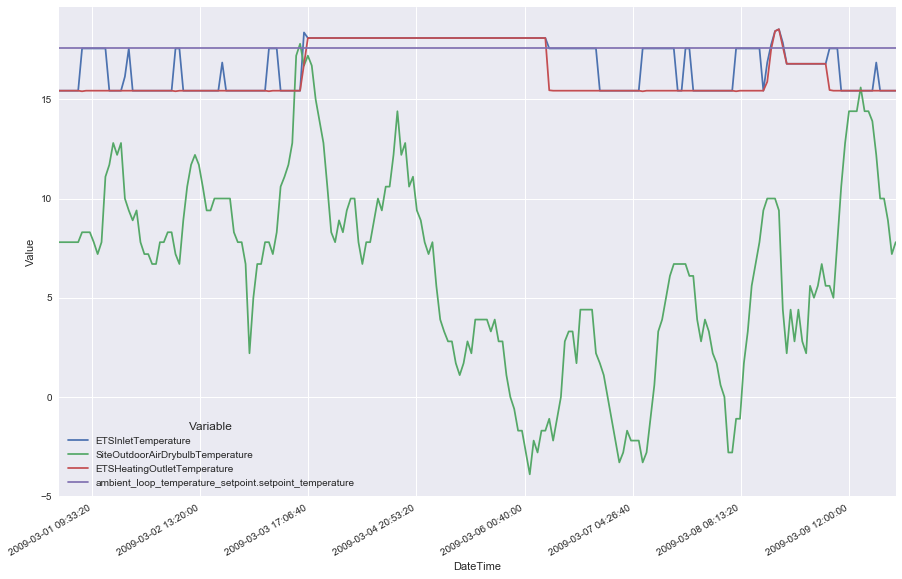

In [29]:
def date_formatter(x, pos):
    return pd.to_datetime(x)

fig, ax = plt.subplots()

sns.tsplot(melted_df, time='DateTime', unit='Dummy', condition='Variable', value='Value', ax=ax)

ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(date_formatter))
# date_formatter = mdates.DateFormatter('%d')
# ax.xaxis.set_major_formatter(myFmt)
# assign locator and formatter for the xaxis ticks.
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))

# put the labels at 45deg since they tend to be too long
fig.autofmt_xdate()
plt.show()

In [ ]:
# load the ROM and run the data through it. Generate the plot